In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
%run -i util.py

In [2]:
MAIN_FOLDER = '../alcala_henares_20180211.prepared/'
IMGS_FOLDER = MAIN_FOLDER + '/rgb'
LABELS_FOLDER = MAIN_FOLDER + '/labels'

In [3]:
cat_cols = [[178, 216, 177], # green
            [255, 255, 255], # white 
            [179, 178, 254], # blue
            [254, 178, 178], # red
            [254, 255, 177], # yellow
            [178, 178, 178]] # gray

cat_names = ["P", "NOT_IN_CATASTRO", "PI", "I/V", "POR/TZA", "ALL_OTHER"]
    
def convert_label_to_single_channel(multi_channel_label_img, channel_map):
    return np.r_[[np.abs(multi_channel_label_img-i).sum(axis=2) for i in channel_map]].argmin(axis=0)

def convert_label_to_multi_channel(single_channel_label_img, channel_map):
    s = single_channel_label_img.shape
    return np.r_[[channel_map[i] for i in single_channel_label_img.flatten()]].reshape( list(s)+[3] ).astype(np.int64)

N_CLASSES = len(cat_cols)
WEIGHTS = torch.ones(N_CLASSES) # Weights for class balancing
IN_CHANNELS=3

In [4]:
print (1,end=' ')
print (2)

1 2


In [5]:
from IPython.display import clear_output

def train(net, optimizer, epochs, scheduler=None, weights=WEIGHTS, save_epoch = 1):
    losses = np.zeros(1000000)
    mean_losses = np.zeros(100000000)
    weights = weights.cuda()

    criterion = nn.NLLLoss2d(weight=weights)
    iter_ = 0
    
    with open("progress.csv", "a") as myfile:
        myfile.write("time,epoch,iter,loss,mean_loss,sample_acc\n")
    last_acc = 0
    for e in range(1, epochs + 1):
        if scheduler is not None:
            scheduler.step()
        net.train()
        for k in enumerate(train_loader):
            batch_idx, (data, target) = k
            data, target = Variable(data.cuda()), Variable(target.cuda())
            optimizer.zero_grad()
            output = net(data)
            loss = CrossEntropy2d(output, target, weight=weights)
            loss.backward()
            optimizer.step()
            
            losses[iter_] = loss.data[0]
            mean_losses[iter_] = np.mean(losses[max(0,iter_-100):iter_])
            date = !date
            print (batch_idx,end=" ")
            with open("progress.csv", "a") as myfile:
                myfile.write("%s, %d, %d, %.5f, %.5f, %.5f\n"%(date[0],e,iter_, losses[iter_], mean_losses[iter_], last_acc))
            
            if iter_ % 2 == 0:
                clear_output()
                rgb = np.asarray(255 * np.transpose(data.data.cpu().numpy()[0],(1,2,0)), dtype='uint8')
                pred = np.argmax(output.data.cpu().numpy()[0], axis=0)
                gt = target.data.cpu().numpy()[0]
                last_acc = accuracy(pred, gt)
                print('Train (epoch {}/{}) [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAccuracy: {}'.format(
                    e, epochs, batch_idx, len(train_loader),
                    100. * batch_idx / len(train_loader), loss.data[0], last_acc))
                plt.plot(mean_losses[:iter_]) and plt.show()
                fig = plt.figure()
                fig.add_subplot(131)
                plt.imshow(rgb)
                plt.title('RGB')
                plt.axis("off")
                fig.add_subplot(132)
                plt.imshow(convert_label_to_multi_channel(gt).astype(np.uint8))
                plt.title('Ground truth')
                plt.axis("off")
                fig.add_subplot(133)
                plt.title('pred %.1f'%last_acc)
                plt.imshow(convert_label_to_multi_channel(pred).astype(np.uint8))
                plt.axis("off")
                plt.show()
            iter_ += 1
            
            del(data, target, loss)
            
        if e % save_epoch == 0:
            torch.save(net.state_dict(), './CAT_segnet256_epoch{}'.format(e))
            # We validate with the largest possible stride for faster computing
#            acc = test(net, test_ids, all=False, stride=min(WINDOW_SIZE))
#            torch.save(net.state_dict(), './CAT_segnet256_epoch{}_{}'.format(e, acc))
    torch.save(net.state_dict(), './CAT_segnet_final')

In [6]:
net = SegNet( in_channels=IN_CHANNELS, out_channels=N_CLASSES)
vgg16_weights = torch.load('./vgg16_bn-6c64b313.pth')
mapped_weights = {}
for k_vgg, k_segnet in zip(vgg16_weights.keys(), net.state_dict().keys()):
    if "features" in k_vgg:
        mapped_weights[k_segnet] = vgg16_weights[k_vgg]
#        print("Mapping {} to {}".format(k_vgg, k_segnet))


In [7]:
net.load_state_dict(torch.load('./CAT_segnet256_epoch38'))
net.cuda();


In [8]:
#train_set = ISPRS_dataset(train_ids, cache=CACHE)
train_set = GMAPS_dataset(IMGS_FOLDER, LABELS_FOLDER, window_size=(256, 256))
train_loader = torch.utils.data.DataLoader(train_set,batch_size=10)

In [9]:
base_lr = 0.01
params_dict = dict(net.named_parameters())
params = []
for key, value in params_dict.items():
    if '_D' in key:
        # Decoder weights are trained at the nominal learning rate
        params += [{'params':[value],'lr': base_lr}]
    else:
        # Encoder weights are trained at lr / 2 (we have VGG-16 weights as initialization)
        params += [{'params':[value],'lr': base_lr / 2}]

optimizer = optim.SGD(net.parameters(), lr=base_lr, momentum=0.9, weight_decay=0.0001)
# We define the scheduler
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, [25, 35, 45], gamma=0.1)

Train (epoch 27/50) [420/1000 (42%)]	Loss: 0.163323	Accuracy: 98.78387451171875


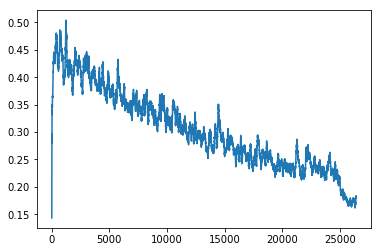

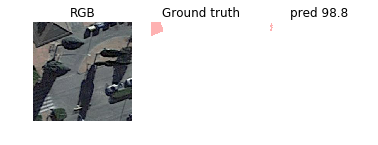

In [ ]:
train(net, optimizer, 50, scheduler)

In [76]:
date=!date
date[0]

'Tue Mar  6 06:55:21 COT 2018'

In [67]:
with open("test.txt", "a") as myfile:
    myfile.write("appended text\n")

In [ ]:
a = np.random.randint([])